### This notebook's purpose is to get the CALCE data in a workable format (in a dataframe, cleaned, battery type labeled etc.)

### Goals: (Add to this)
1. Get files from CALCE website into dataframe(s)
2. Add label for every cycle which battery this data came from 
3. Find/Remove empty cells  (delete the whole row or should we do interpolation?) (Might not even have empty cells)


All CS2 cells underwent the same charging profile which was a standard constant current/constant voltage protocol with a constant current rate of 0.5C until the voltage reached 4.2V and then 4.2V was sustained until the charging current dropped to below 0.05A. Unless specified, the discharge cut off voltage for these batteries was 2.7V. All the CS2 cells were randomly numbered and named accordingly. Name 'CS2_n' was given for the nth numbered CS2 cell. 

#### Imports:

In [2]:
import scipy.io
import scipy.signal
import os 
import pandas as pd
from pandas import ExcelWriter
#also had to pip install openpyxl
import requests
from math import isclose


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Notes:
To import .mat files into python:  
import scipy.io   
mat = scipy.io.loadmat('file.mat')  

To unzip files: look at SEDS HW2 (not sure if we will use this)


#### CS2 data (in excel format*)  
Look at CS2 data first. From the website, CS2_'n' was given to the nth numbered CS2 cell (identifies unique cells from eachother). Each cell was cycled multiple times. Excel files are named using the testing dates.  **Were the same cells cycled on different dates or was the continuous cycling data split into multiple excel files?**   

*CS2_8 and CS2_21 are in .txt format because they were cycled using a different system.

Starting with CS2_33, in excel file format

In [101]:
#also had to pip install openpyxl
import glob 
from math import isclose
import os 
import pandas as pd
from pandas import ExcelWriter
import requests
import scipy.io
import scipy.signal

### Wrapper Functions below - load_sep_cycles and clean_calc_sep_smooth

def load_sep_cycles(getdata_filepath, savedata_filepath):
    """Get data from a specified filpath, separates out data into cycles and saves those cycles as .xlsx files in specified filepath (must be an existing folder)"""
    dfdict = get_data(getdata_filepath)
    for key in dfdict:
        all_cycles_df = dfdict[key]
        cycle_dict = sep_cycles(all_cycles_df)
        battname = key 
        save_sep_cycles_xlsx(cycle_dict, battname, savedata_filepath) 
    print('All data separated into cycles and saved')
    return 

def clean_calc_sep_smooth(dataframe, windowlength, polyorder):
    """Takes one cycle dataframe, calculates dq/dv, cleans the data, separates out charge and discharge, and applies sav-golay filter. Returns two dataframes, one charge and one discharge.
    Windowlength and polyorder are for the sav-golay filter."""
    df1 = calc_dv_dqdv(dataframe)
    df2 = drop_0_dv(df1)
    charge, discharge = sep_char_dis(df2)
    if len(discharge) > windowlength:
        smooth_discharge = my_savgolay(discharge, windowlength, polyorder)
    else:
        discharge['Smoothed_dQ/dV'] = discharge['dQ/dV']
        smooth_discharge = discharge
    if len(charge) > windowlength: 
        smooth_charge = my_savgolay(charge, windowlength, polyorder)
    else:
        charge['Smoothed_dQ/dV'] = charge['dQ/dV']
        smooth_charge = charge   
    return smooth_charge, smooth_discharge


### Component Functions Below


def get_data(filepath): 
    """Imports all data in given path"""
    rootdir = filepath
    file_list = [f for f in glob.glob(os.path.join(rootdir,'*.xlsx'))] #iterate through dir to get excel files 
    
    d = {} #initiate dict for data storage
    count = 0
    for file in file_list:
        count += 1
        name = os.path.split(file)[1].split('.')[0]
        data = pd.read_excel(file,1)
        new_set = {name : data}
        d.update(new_set)
        print("adding file " + str(count) + ' ' + str(name))
    return d
### There are 23 files in the CS2 directory, so we should have 23 entries in the dictionary - add unit test for this, super EASY check 

#separate out dataframes into cycles
def sep_cycles(dataframe):
    """This function separates out the cycles in the battery dataframe by grouping by the 'Cycle_Index' column, and putting them in a dictionary. """
    gb = dataframe.groupby(by = ['Cycle_Index'])
    cycle_dict = dict(iter(gb))
    return cycle_dict

def save_sep_cycles_xlsx(cycle_dict, battname, path_to_folder):
    '''This saves the separated out cycles into different excel files, beginning with the battery name. Battname and path to folder must be strings.'''
    for i in range(1, len(cycle_dict)):
         cycle_dict[i]['Battery_Label'] = battname
    for i in range(1,len(cycle_dict)):
        writer = ExcelWriter(path_to_folder + battname + 'Cycle' + str(i) + '.xlsx')
        cycle_dict[i].to_excel(writer)
        writer.save()
    return 


def calc_dv_dqdv(cycle_df):
    '''This function calculates the dv and the dq/dv for a dataframe.'''
    cycle_df = cycle_df.reset_index(drop = True)
    cycle_df['dV'] = None 
    cycle_df['dQ/dV'] = None 
    for i in range(1,len(cycle_df)): 
        cycle_df.loc[i, ('dV')] = cycle_df.loc[i, ('Voltage(V)')] - cycle_df.loc[i-1, ('Voltage(V)')]
    #calculate dq/dv based off of discharge capacity - might change this later so user can choose to use charge or discharge cap. 
    cycle_df['dQ/dV'] = cycle_df['Discharge_Capacity(Ah)']/cycle_df['dV']
    return cycle_df

def drop_0_dv(cycle_df_dv): 
    '''Drop rows where dv=0 (or about 0) in a dataframe that has already had dv calculated. Then recalculate dv and calculate dq/dv'''
    #this will clean up the data points around V = 4.2V (since they are holding it at 4.2V for a while).
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
   
    cycle_df_dv['dv_close_to_zero'] = None
    
    for i in range(1, len(cycle_df_dv)):
        if isclose(cycle_df_dv.loc[i, ('dV')], 0, abs_tol = 10**-3.5):
            cycle_df_dv.loc[i,('dv_close_to_zero')] = False
        else:
            cycle_df_dv.loc[i,('dv_close_to_zero')]= True   
    
    
    while (False in cycle_df_dv['dv_close_to_zero'].values or cycle_df_dv['dV'].max() > 0.7 or cycle_df_dv['dV'].min() < -0.7): 
        
        cycle_df_dv = cycle_df_dv.reset_index(drop = True)
        
        for i in range(1, len(cycle_df_dv)):
            if isclose(cycle_df_dv.loc[i, ('dV')], 0, abs_tol = 10**-3.5): 
                cycle_df_dv = cycle_df_dv.drop(index = i)
                
        cycle_df_dv = cycle_df_dv.reset_index(drop = True)
        
        for i in range(1, len(cycle_df_dv)):
            if (cycle_df_dv.loc[i,('dV')] > 0.7 or cycle_df_dv.loc[i,('dV')] < -0.7):
                cycle_df_dv = cycle_df_dv.drop(index = i)       
                
        cycle_df_dv = cycle_df_dv.reset_index(drop = True)
        
        for i in range(1, len(cycle_df_dv)): 
            cycle_df_dv.loc[i, ('dV')] = cycle_df_dv.loc[i, ('Voltage(V)')] - cycle_df_dv.loc[i-1, ('Voltage(V)')] 
            cycle_df_dv.loc[i, ('d(dq/dv)')] = cycle_df_dv.loc[i, ('dQ/dV')] - cycle_df_dv.loc[i-1, ('dQ/dV')]
            if isclose(cycle_df_dv.loc[i, ('dV')], 0, abs_tol = 10**-3.5):
                cycle_df_dv.loc[i,('dv_close_to_zero')] = False
            else:
                cycle_df_dv.loc[i,('dv_close_to_zero')]= True
                
        cycle_df_dv = cycle_df_dv.reset_index(drop = True)            
    
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
   
    #recalculating dv after dropping rows
    for i in range(1, len(cycle_df_dv)): 
        cycle_df_dv.loc[i, ('dV')] = cycle_df_dv.loc[i, ('Voltage(V)')] - cycle_df_dv.loc[i-1, ('Voltage(V)')]
        
    #recalculate dq/dv  
    cycle_df_dv['dQ/dV'] = cycle_df_dv['Discharge_Capacity(Ah)']/cycle_df_dv['dV']
    cycle_df_dv = cycle_df_dv.dropna(subset=['dQ/dV'])
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
    cycle_df_dv = cycle_df_dv[:-1]
   
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
    return cycle_df_dv  

def sep_char_dis(df_dqdv):
    '''Takes a dataframe of one cycle with calculated dq/dv and separates into charge and discharge differential capacity curves'''
    charge = df_dqdv[df_dqdv['dV'] < 0] 
    charge = charge.reset_index(drop = True)
    charge = charge.iloc[6:]
    charge = charge.reset_index(drop = True)
    discharge = df_dqdv[df_dqdv['dV'] > 0] 
    discharge = discharge.reset_index(drop = True)
    discharge = discharge.iloc[:-2]
    discharge = discharge.iloc[2:]
    discharge = discharge.reset_index(drop = True)
    
    return charge, discharge
    
def my_savgolay(dataframe, windowlength, polyorder):
    """Takes battery dataframe with a dQ/dV column and applies a sav_golay filter to it, returning the dataframe with a new column called Smoothed_dQ/dV"""
    unfilt = pd.concat([dataframe['dQ/dV']])
    unfiltar = unfilt.values
    #converts into an array 
    dataframe['Smoothed_dQ/dV'] = scipy.signal.savgol_filter(unfiltar, windowlength, polyorder)
    #had windowlength = 21 and polyorder = 3 before
    return dataframe




In [102]:
#load_sep_cycles('data/CS2_33/', 'NLT_Test/')

In [161]:
mytestdf = pd.read_excel('NLT_Test/NLT_TestSepCycles/3_4_14_1C_CycleCycle12.xlsx')
#still having problems with CS2_33_1_10_11Cycle1.xlsx - guessing all cycle1 discharges will have to be deleted 

In [162]:
len(mytestdf)

153

In [163]:
mytestdf2 = calc_dv_dqdv(mytestdf)

In [164]:
mytestdf2['dV'].mean()

0.0005955351026434662

In [165]:
mytestdf3 = drop_0_dv(mytestdf2)

In [166]:
mytestdf3.shape

(139, 22)

In [167]:
mytestdf2.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),Battery_Label,dV,dQ/dV
0,1683,49537.144747,2014-02-26 23:30:12,30.015167,4,12,0.000000,4.009059,15.738001,15.690905,54.858208,47.694496,-0.002235,0.056130,0,0,0,3_4_14_1C_Cycle,None,NaN
1,1684,49567.159960,2014-02-26 23:30:43,60.030380,4,12,0.000000,3.946229,15.738001,15.690905,54.858208,47.694496,-0.001684,0.056130,0,0,0,3_4_14_1C_Cycle,-0.0628302,-249.735
2,1685,49597.175121,2014-02-26 23:31:13,90.045541,4,12,0.000000,3.896515,15.738001,15.690905,54.858208,47.694496,-0.001425,0.056130,0,0,0,3_4_14_1C_Cycle,-0.0497139,-315.624
3,1686,49627.143179,2014-02-26 23:31:42,120.013599,4,12,0.000000,3.856194,15.738001,15.690905,54.858208,47.694496,-0.001166,0.056130,0,0,0,3_4_14_1C_Cycle,-0.0403214,-389.146
4,1687,49627.158075,2014-02-26 23:31:43,0.015616,5,12,-0.000354,3.856194,15.738001,15.690905,54.858208,47.694496,0.000000,0.043455,0,0,0,3_4_14_1C_Cycle,0,inf


(-20000, 20000)

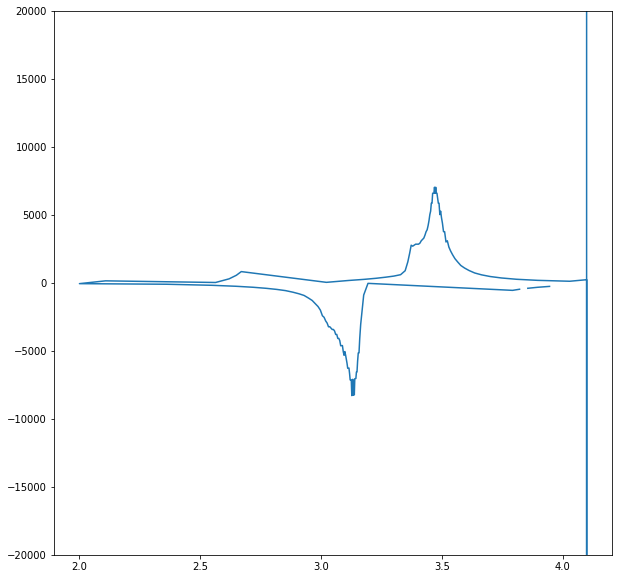

In [168]:
fig1 = plt.figure(figsize = (10,10), facecolor = 'w', edgecolor= 'k')
myplot = plt.plot(mytestdf2['Voltage(V)'], mytestdf2['dQ/dV'])
plt.ylim(-20000, 20000)

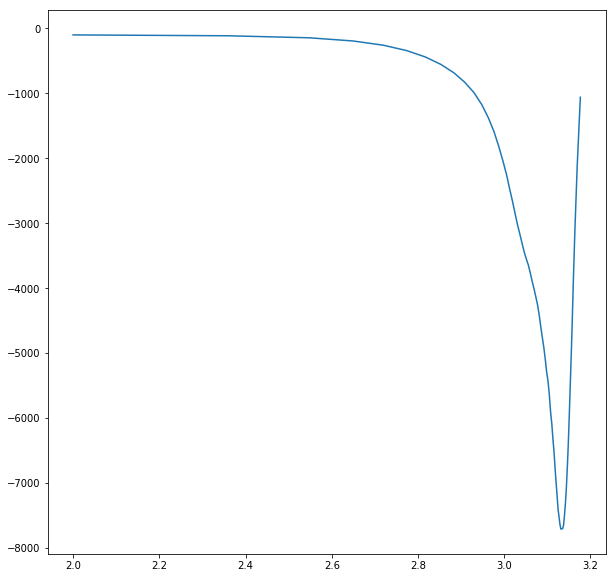

In [169]:
charge, discharge = clean_calc_sep_smooth(mytestdf, 21, 3)
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(charge['Voltage(V)'], charge['Smoothed_dQ/dV'])

In [170]:
charge['dV'].max()

-0.0019431114196768462

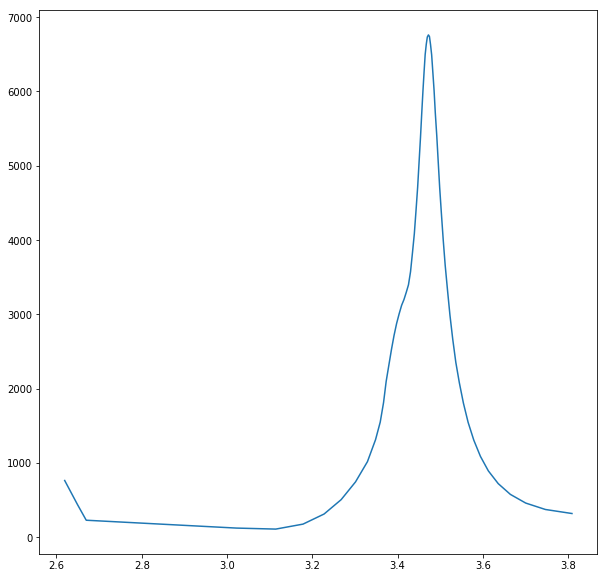

In [171]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(discharge['Voltage(V)'], discharge['Smoothed_dQ/dV'])

### From Robert's Notebook + Sarah's Edits:

In [ ]:
d = get_data('data/CS2_33/')

In [ ]:
data1 = d['CS2_33_10_05_10']

In [ ]:
data1['Cycle_Index'].max()

In [ ]:
#add_label_dv_cols(dictionary = d)

In [ ]:
#separate out dataframes into cycles
def sep_cycles(dataframe):
    """This function separates out the cycles in the battery dataframe by grouping by the 'Cycle_Index' column, and putting them in a dictionary. """
    gb = dataframe.groupby(by = ['Cycle_Index'])
    cycle_dict = dict(iter(gb))
    return cycle_dict

In [ ]:
test = sep_cycles(data1)
#test is a dictionary of cycles

In [ ]:

#writer = ExcelWriter('NLToutput.xlsx')
#test[1].to_excel(writer)
#writer.save()

In [ ]:
def save_sep_cycles_xlsx(cycle_dict, battname, path_to_folder):
    '''This saves the separated out cycles into different excel files, beginning with the battery name. Battname and path to folder must be strings.'''
    for i in range(1, len(cycle_dict)):
         cycle_dict[i]['Battery_Label'] = battname
    for i in range(1,len(cycle_dict)):
        writer = ExcelWriter(path_to_folder + battname + 'Cycle' + str(i) + '.xlsx')
        cycle_dict[i].to_excel(writer)
        writer.save()
    return 


In [ ]:
#save_sep_cycles_xlsx(test, 'NLTtest2', 'NLT_Test/')

In [ ]:
testdata = pd.read_excel('NLT_Test/CS2_33_10_04_10Cycle14.xlsx')

In [ ]:
testdata.head()

### Calculate dV and dq/dv and Clean Data 

In [ ]:
def calc_dv_dqdv(cycle_df):
    '''This function calculates the dv and the dq/dv for a dataframe.'''
    cycle_df = cycle_df.reset_index(drop = True)
    cycle_df['dV'] = None 
    cycle_df['dQ/dV'] = None 
    for i in range(1,len(cycle_df)): 
        cycle_df.loc[i, ('dV')] = cycle_df.loc[i, ('Voltage(V)')] - cycle_df.loc[i-1, ('Voltage(V)')]
    #calculate dq/dv based off of discharge capacity - might change this later so user can choose to use charge or discharge cap. 
    cycle_df['dQ/dV'] = cycle_df['Discharge_Capacity(Ah)']/cycle_df['dV']
    return cycle_df

In [ ]:
testdata3 = calc_dv_dqdv(testdata)

In [ ]:
testdata3.tail(50)

In [ ]:
480 in testdata3.index

In [ ]:
testdata3['dV'].max() > 0.9

In [ ]:
#testdata2 = testdata2.reset_index(drop = True)

In [ ]:
def drop_0_dv(cycle_df_dv): 
    '''Drop rows where dv=0 (or about 0) in a dataframe that has already had dv calculated. Then recalculate dv and calculate dq/dv'''
    #this will clean up the data points around V = 4.2V (since they are holding it at 4.2V for a while).
    
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
    
    for i in range(1, len(cycle_df_dv)):
        if isclose(cycle_df_dv.loc[i, ('dV')], 0, abs_tol = 10**-3):
            cycle_df_dv = cycle_df_dv.drop(index = i)
            
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
    
    while (cycle_df_dv['dV'].max() > 0.05 or cycle_df_dv['dV'].min() < -0.05):
        for i in range(1, len(cycle_df_dv)):    
            if (cycle_df_dv.loc[i,('dV')] > 0.05 or cycle_df_dv.loc[i,('dV')] < -0.05):
                cycle_df_dv = cycle_df_dv.drop(index = i)
                if i-1 in cycle_df_dv.index:
                    cycle_df_dv = cycle_df_dv.drop(index = i-1)
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)            
    
    #recalculating dv after dropping rows
    for i in range(1, len(cycle_df_dv)): 
        cycle_df_dv.loc[i, ('dV')] = cycle_df_dv.loc[i, ('Voltage(V)')] - cycle_df_dv.loc[i-1, ('Voltage(V)')]
    #recalculate dq/dv  
    cycle_df_dv['dQ/dV'] = cycle_df_dv['Discharge_Capacity(Ah)']/cycle_df_dv['dV']
    cycle_df_dv = cycle_df_dv.dropna(subset=['dQ/dV'])
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
    return cycle_df_dv  

In [ ]:
data3_again = drop_0_dv(testdata3)

### Separate by charge/discharge 
#### We want to take each cycle as an individual, but we also want to separate into charge+discharge just to do gaussian fitting easier, but still take charge+discharge as one set. So after cycles are separated out to be treated as individuals, we will run above code to smooth, separate them into charge and discharge (could reverse those two steps) and then do gaussian fitting to find peak descriptors. 

In [ ]:
data5 = calc_dv_dqdv(data3)

In [ ]:
data6 = drop_0_dv(data5)

In [ ]:
def sep_char_dis(df_dqdv):
    '''Takes a dataframe of one cycle with calculated dq/dv and separates into charge and discharge differential capacity curves'''
    charge = df_dqdv[df_dqdv['dV'] < 0] 
    charge = charge.reset_index(drop = True)
    discharge = df_dqdv[df_dqdv['dV'] > 0] 
    discharge = discharge.reset_index(drop = True)
    return charge, discharge
    

In [ ]:
charge, discharge = sep_char_dis(data6)

In [ ]:
charge.tail(3)

### Filter Sav Golay

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(discharge['Voltage(V)'], discharge['dQ/dV'])

In [ ]:
def my_savgolay(dataframe, windowlength, polyorder):
    """Takes battery dataframe with a dQ/dV column and applies a sav_golay filter to it, returning the dataframe with a new column called Smoothed_dQ/dV"""
    unfilt = pd.concat([dataframe['dQ/dV']])
    unfiltar = unfilt.values
    #converts into an array 
    dataframe['Smoothed_dQ/dV'] = scipy.signal.savgol_filter(unfiltar, windowlength, polyorder)
    #had windowlength = 21 and polyorder = 3 before
    return dataframe 

In [ ]:
data7 = my_savgolay(discharge, 21, 3)

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(data7['Voltage(V)'], data7['Smoothed_dQ/dV'])

### Entire Function 

In [ ]:
#imports
def load_sep_cycles(getdata_filepath, savedata_filepath):
    dfdict = get_data(getdata_filepath)
    for key in dfdict:
        all_cycles_df = dfdict[key]
        cycle_dict = sep_cycles(all_cycles_df)
        battname = key 
        save_sep_cycles_xlsx(cycle_dict, battname, savedata_filepath) 
    print('All data separated into cycles and saved')
    return 
#download all files from one folder into a dictionary 
#separate each df in dictionary into cycles & save to excel sheets in new folder - this becomes our raw set of test/train data?

def clean_calc_sep_smooth(dataframe, windowlength, polyorder):
    """Takes one cycle dataframe, calculates dq/dv, cleans the data, separates out charge and discharge, and applies sav-golay filter. Returns two dataframes, one charge and one discharge.
    Windowlength and polyorder are for the sav-golay filter."""
    df1 = calc_dv_dqdv(dataframe)
    df2 = drop_0_dv(df1)
    charge, discharge = sep_char_dis(df2)
    smooth_charge = my_savgolay(charge, windowlength, polyorder)
    smooth_discharge = my_savgolay(discharge, windowlength, polyorder)
    return smooth_charge, smooth_discharge



In [ ]:
load_sep_cycles('data/CS2_33/', 'NLT_Test/')

In [ ]:
nltdf = pd.read_excel('NLT_Test/CS2_33_10_04_10Cycle16.xlsx')

In [ ]:
nltdf.head()

In [ ]:
nltdf2_charge, nltdf2_discharge = clean_calc_sep_smooth(nltdf, 21, 3)

In [ ]:
nltdf2_charge.head()

### Plot code

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(nltdf2_discharge['Voltage(V)'], nltdf2_discharge['Smoothed_dQ/dV'])